In [128]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import plotly.graph_objects as go
from matplotlib.sankey import Sankey
from wordcloud import WordCloud,STOPWORDS
import warnings
warnings.filterwarnings("ignore")


In [130]:
#Step 1 Load the Excel File
data = pd.ExcelFile('V02Max_Combined.xlsx')
#Get the sheet names
sheet = data.sheet_names
print('\nData set Sheet Names\n',sheet)

#Step 2 Read each sheet 
data_Kayaking = pd.read_excel(data,sheet_name = 'Kayaking')
data_Athletes = pd.read_excel(data, sheet_name = 'Athletes')
data_Triathlon = pd.read_excel(data,sheet_name =  'Triathlon')
data_Fencing = pd.read_excel(data,sheet_name =  'Fencing')

#Step 3 verify dataframes
print('\ndata_Kayaking\n',data_Kayaking.head())
print('\ndata_Athletes\n',data_Athletes.head())
print('\ndata_Triathlon\n',data_Triathlon.head())
print('\ndata_Fencing\n',data_Fencing.head())

#Step 4 Load the Merged Excel File
data_merged = pd.ExcelFile('merged_athletes_data.xlsx')
#Get the sheet names
merged_sheet = data_merged.sheet_names
print('\nSheet Names:\n',merged_sheet)

#Step 5 Read sheet
data_merged_sheet= pd.read_excel(data_merged,sheet_name = 'Sheet1')
#Step 6 verify dataframe
print('\ndata_merged_sheet\n',data_merged_sheet.head())

#Step 7 Load the Criteria Excel File
data_criteria=pd.ExcelFile('crieteria_data.xlsx')
#Step 8 Read sheet
data_criteria_sheet= pd.read_excel(data_criteria,sheet_name = 'Sheet1')
print('\nData set Criteria Sheet Names:\n',data_criteria_sheet)
#Step 9 verify dataframe
print('\ndata_criteria_sheet\n',data_criteria_sheet.head())


Data set Sheet Names
 ['Kayaking', 'Athletes', 'Triathlon', 'Fencing']

data_Kayaking
    ID     time     RR       VO2  power
0  11 -168.600  727.0  0.287147      0
1  11 -167.872  728.0  0.287147      0
2  11 -167.148  724.0  0.287147      0
3  11 -166.484  664.0  0.320580      0
4  11 -165.836  648.0  0.320580      0

data_Athletes
    ID  age  Weight  Height  P_vt1  P_vt2    sport  Gender Ethnicity  \
0   1   15    53.7     161     50    140  fencing  Female   African   
1   2   15    56.2     162     80    127  fencing    Male   African   
2   3   16    89.9     191    155    300  fencing    Male     White   
3   4   16    76.5     180    215    275  fencing    Male     White   
4   5   17    76.4     186    110    172  fencing  Female     White   

  First Name Last Name  
0     Olivia  Martinez  
1      Ethan  Reynolds  
2    Jackson    Harper  
3       Liam   Sanchez  
4        Ava  Thompson  

data_Triathlon
    ID     time     RR       VO2  power
0  17 -182.408  736.0  0.3637

21.Display a pie chart of number of athletes by sport.

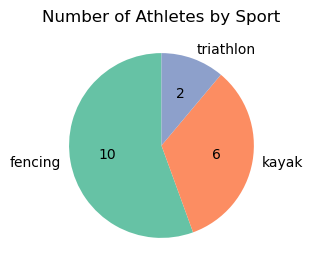

In [59]:
#step 1 Count the Athletes by Sport by accessing the sport column in Data Atheletes Data frame
count=data_Athletes['sport'].value_counts()
#Step 2 Create figure with size 4*3 inches
plt.figure(figsize=(4, 3))
#Step 3 Create pie chart and format the labels 
labels_sport=data_Athletes['sport'].unique()

plt.pie(count, 
        labels=labels_sport,
        labeldistance=1.1,
        autopct=lambda x: '{:.0f}'.format(x * (data_Athletes['sport'].count()) / 100),
        textprops={'fontsize':10},
        colors=sns.color_palette('Set2'),
        startangle=90)
#Step 4 Adds a title
plt.title('Number of Athletes by Sport')
#Step 5 Displays Pie chart
plt.show()

22.Using any 10 HR values print even if the value is an even number and odd if its an odd number

In [53]:
#Step 1 Random 10 values from RR column by using samplefunction,
#random_state=1( same values will be sampled every time)
RR=data_Triathlon['RR'].sample(n=10,random_state=1)

#Step 2 Heart Rate for every Random RR value
HR=[60/(RR/1000) for RR in RR]

#Step 3 checking each iterable value odd or even
for i in HR:
    if i%2==0:
        #Step 4 Format using string literal values with 2 decimal point and printing odd or even status
        print(f"{i:.2f} : even")
      
    else:
        print(f"{i:.2f} : odd")


131.58 : odd
127.12 : odd
166.67 : odd
137.61 : odd
132.74 : odd
126.05 : odd
82.42 : odd
132.74 : odd
142.86 : odd
150.00 : even


23. Which heart rate zone did most participants spend the longest duration of time in?

In [83]:
# Copy dataframes to New to avoid merge conflicts
data_Athlete_sheet = data_Athletes.copy()
copy_data_merged_sheet = data_merged_sheet.copy()

#Print the columns of the working datasets
#print('\nNew data_Athletes Columns:\n', data_Athlete_sheet.columns)
#print('\nCopy data_merged_sheet Columns:\n', copy_data_merged_sheet.columns)

# Step 1: Calculate the maximum heart rate for each athlete based on their age
data_Athlete_sheet['Athlete_MaxHeartRate'] = 220 - data_Athlete_sheet['age']

# Step 2: Calculate heart rate from RR intervals 
copy_data_merged_sheet['HR'] = 60 / (copy_data_merged_sheet['RR'] / 1000)

# Step 3: Merge Athlete_MaxHeartRate into copy_data_merged_sheet based on 'ID'
if 'Athlete_MaxHeartRate' not in copy_data_merged_sheet.columns:
    copy_data_merged_sheet = copy_data_merged_sheet.merge(
        data_Athlete_sheet[['ID', 'Athlete_MaxHeartRate']], on='ID', how='left', copy=False)

#Step 4: Remove any duplicate columns, keeping only unique ones to avoid merge conflicts
#data_merged_sheet.columns.duplicated() Boolean array to indicate which columns are duplicate
#~bitwise operator for inverting above function
#:to include all rows 
copy_data_merged_sheet = copy_data_merged_sheet.loc[:, ~copy_data_merged_sheet.columns.duplicated()]

# Print the columns after cleanup
#print('\nData Merged Columns after cleanup:\n', copy_data_merged_sheet.columns)

# Step 5: Define a function to categorize heart rate zones

#Zone 1 (recovery/easy)  55%-65% HR max      
#Zone 2 (aerobic/base)   65%-75% HR max     
#Zone 3 (tempo)          80%-85% HR max
#Zone 4 (lactate threshold) 85%-88% HR max       
#Zone 5 (anaerobic) 90% HR max and above 

def determine_hr_zone(heart_rate, max_heart_rate):
    if heart_rate <= 0.6 * max_heart_rate:
        return 'Recovery/Easy Zone (Zone 1)'
    elif heart_rate <= 0.7 * max_heart_rate:
        return 'Aerobic/Base Zone (Zone 2)'
    elif heart_rate <= 0.8 * max_heart_rate:
        return 'Tempo Zone (Zone 3)'
    elif heart_rate <= 0.9 * max_heart_rate:
        return 'Lactate Threshold Zone (Zone 4)'
    return 'Anaerobic Zone (Zone 5)'

# Step 6: Assign heart rate zones to each athlete's performance data using lambda function
if 'Athlete_MaxHeartRate' in copy_data_merged_sheet.columns:
    copy_data_merged_sheet['HeartRateZone'] = copy_data_merged_sheet.apply(
        lambda row: determine_hr_zone(row['HR'], row['Athlete_MaxHeartRate']),
        axis=1
    )

# Step 7: Aggregate the time spent in each heart rate zone
zone_time_distribution = copy_data_merged_sheet.groupby('HeartRateZone')['time'].sum()

# Step 8: Identify the heart rate zone with the most time spent
dominant_zone = zone_time_distribution.idxmax()

# Step 9: Print the dominant heart rate zone
print(f"The heart rate zone with the highest time spent by athletes is: {dominant_zone}")


The heart rate zone with the highest time spent by athletes is: Lactate Threshold Zone (Zone 4)


24.Store athlete name and sport in a dictionary as a pair of values.

In [116]:
#Step 1 creating dictionary and concatinating first and last names
athelete_sport_dict=data_Athletes.set_index(data_Athletes['First Name']+ ' '+data_Athletes['Last Name']).to_dict('dict')['sport']
#Step 2 verifying the created dictionary
print(athelete_sport_dict)

{'Olivia Martinez': 'fencing', 'Ethan Reynolds': 'fencing', 'Jackson Harper': 'fencing', 'Liam Sanchez': 'fencing', 'Ava Thompson': 'fencing', 'Sophia Rodriguez': 'fencing', 'Grace Simmons': 'fencing', 'Aiden Bennett': 'fencing', 'Chloe Price': 'fencing', 'Lily Jordan': 'fencing', 'Isabella Griffin': 'kayak', 'Caleb Dixon': 'kayak', 'Mia Carpenter': 'kayak', 'Harper Mitchell': 'kayak', 'Mason Wallace': 'kayak', 'Logan Anderson': 'kayak', 'Lucas Foster': 'triathlon', 'Owen Myers': 'triathlon'}


In [ ]:
25. Using arrays and loops, find the count of athletes based on gender.

In [348]:
#Step 1 Initialize counters to get the count
male_counter=0
female_counter=0
#Step 2 Converting gender to array
gen_array=data_Athletes['Gender'].values
#print(type(gen_array))

#Step 3 Iterate each row and update counter 
for i in gen_array:
    if i =='Female':
        female_counter = female_counter+1             
    else:
        male_counter = male_counter+1
#Step 4 Print count of athletes based on gender     
print('No of athletes in Female Categry:',female_counter)
print('No of athletes in Male Categry:',male_counter)

<class 'numpy.ndarray'>
No of athletes in Female Categry: 10
No of athletes in Male Categry: 8


26.Create a sankey diagram to show the groups of race within each sport

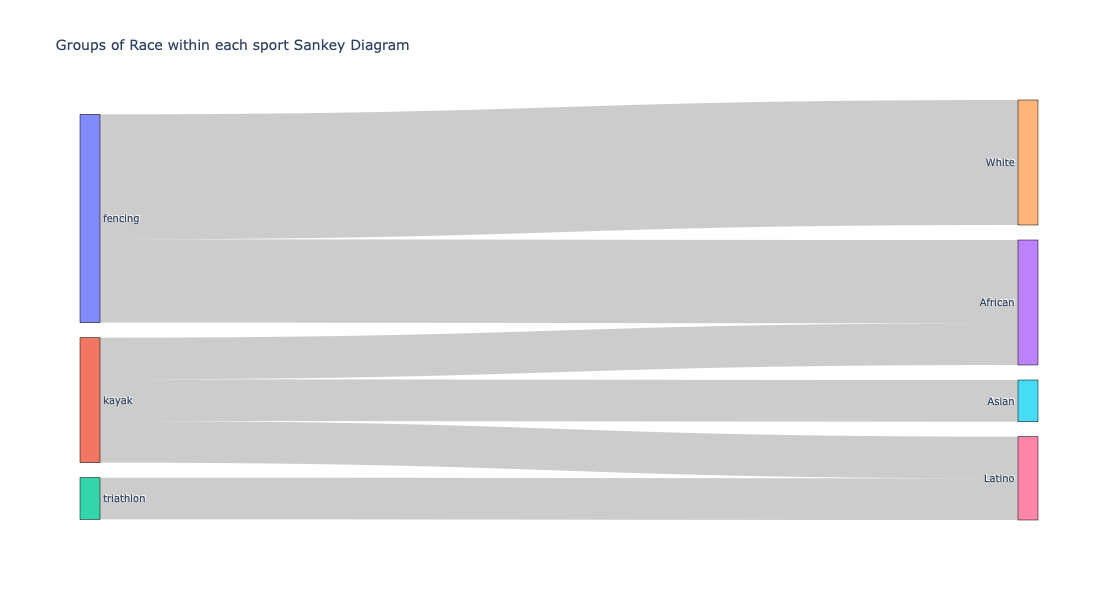

In [127]:
#Step 1 Group Data by sport and Ethnicity and count 
sport_race_group=data_Athletes.groupby(['sport', 'Ethnicity']).size().reset_index(name='count')
#Step 2 Renaming Columns 
sport_race_group.columns=['source','target','value']

#Step 3 Creating List of Unique values
unique_source_target_values = list(pd.unique(sport_race_group[['source', 'target']].values.ravel('K')))


#Step 4 assigning unique number to each source and target
mapping_dictionary = {k: v for v, k in enumerate(unique_source_target_values)}


#Step 5 mapping of full data
sport_race_group['source']=sport_race_group['source'].map(mapping_dictionary)

sport_race_group['target']=sport_race_group['target'].map(mapping_dictionary)


#Step 6 converting full dataframe as list for using with in plotly
links_dict = sport_race_group.to_dict(orient='list')

#Step 7 Sankey Diagram 
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label =unique_source_target_values,      
    ),
    link = dict(
      source = links_dict["source"],
      target = links_dict["target"],
      value = links_dict["value"],
  
  ))])
#Step 8 Update and show plot
fig.update_layout(title_text="Groups of Race within each sport Sankey Diagram", font_size=10,width=1000, height=600)
fig.show()



27.Calculate the average heart rate for every minute for every athlete and add it as a column in the same dataframe.

In [87]:
#Copy dataframes to New to avoid merge conflicts
average_heart_rate_copy_data_merged_sheet = data_merged_sheet.copy()
#Step 1: Converts the time column to a datetime format to enable time-based resampling.
average_heart_rate_copy_data_merged_sheet['time'] = pd.to_datetime(average_heart_rate_copy_data_merged_sheet['time'])
#Step 2 : Calculate Average Heart Rate
average_heart_rate_copy_data_merged_sheet['HR'] = 60 / (average_heart_rate_copy_data_merged_sheet['RR'] / 1000)
#Step 3: Set time column has index 
average_heart_rate_copy_data_merged_sheet.set_index('time', inplace=True)
#Step 4: Resampling HR as 60 seconds interval
average_hr_per_minute = average_heart_rate_copy_data_merged_sheet.resample('60s').agg({'HR': 'mean'}).reset_index()


#Step 5: Merge back the average HR into the original DataFrame
average_heart_rate_copy_data_merged_sheet = average_heart_rate_copy_data_merged_sheet.reset_index().merge(average_hr_per_minute, on='time', suffixes=('', '_avg'))

#Step 6:verage_heart_rate_copy_data_merged_sheet .columns.duplicated() Boolean array to indicate which columns are duplicate
#~bitwise operator for inverting above function
#:to include all rows 

average_heart_rate_copy_data_merged_sheet  = average_heart_rate_copy_data_merged_sheet .loc[:, ~average_heart_rate_copy_data_merged_sheet .columns.duplicated()]


#Step 7: Display the updated DataFrame
print(average_heart_rate_copy_data_merged_sheet.head())


        time  ID     RR      VO2  power         HR  Athlete_MaxHeartRate_x  \
0 1970-01-01  11  612.0  0.82030      0  98.039216                     202   
1 1970-01-01  11  632.0  0.82030     50  94.936709                     202   
2 1970-01-01  11  704.0  0.82030     50  85.227273                     202   
3 1970-01-01  12  812.0  0.68564      0  73.891626                     202   
4 1970-01-01  12  816.0  0.68564     50  73.529412                     202   

                 HeartRateZone  Athlete_MaxHeartRate_y  Athlete_MaxHeartRate  \
0  Recovery/Easy Zone (Zone 1)                     202                   202   
1  Recovery/Easy Zone (Zone 1)                     202                   202   
2  Recovery/Easy Zone (Zone 1)                     202                   202   
3  Recovery/Easy Zone (Zone 1)                     202                   202   
4  Recovery/Easy Zone (Zone 1)                     202                   202   

       HR_avg  
0  149.635178  
1  149.635178  
2 

In [ ]:
28.Print athlete 15s Age and Pvt1 using the format() function

In [95]:
#Step 1 : Store Athlete 15 data 
athlete_15_data=data_Athletes[data_Athletes['ID']==15].iloc[0]
#print(athlete_15_data)

#Step 2 : Seperate age from athelete 15 
athelete_age=athlete_15_data['age']
#print(athelete_age)

#Step 3 : Seperate P_vt1 from athelete 15 
athelete_p_vt1=athlete_15_data['P_vt1']
#print(athelete_p_vt1)

#Step 4:Use format function to print data
print("Athelete ID : 15  \nAge : {:>2} \nP_vt1 : {:>2}".format(athelete_age,athelete_p_vt1))

Athelete ID : 15  
Age : 13 
P_vt1 : 125


29.On average how long was each participants’ warm up?

In [146]:
#Step 1: from data_criteria_sheet check warmup in phase column and store in seperate varible
athlete_warmup=data_criteria_sheet[data_criteria_sheet['phase']=='Warm Up']
#print(athlete_warmup)

#step 2: group by ID and aggregate time 
group_participant=athlete_warmup.groupby('ID')['time'].sum()
#print(group_participant)

#step 3: since warmup values are -ve,converting them to absolute value 
group_participant_abs=group_participant.abs()

#step4:chnge the format to minutes
group_participant_min=group_participant_abs/60

#Step 5:print average time of every athlete
print("Warm up duration for each participant:")
for athlete_id,avg_time in group_participant_min.items():
    print(f" Athlete ID {athlete_id} : Average time {avg_time:.2f} (minutes) ")

Warm up duration for each participant:
 Athlete ID 1 : Average time 189.90 (minutes) 
 Athlete ID 2 : Average time 439.79 (minutes) 
 Athlete ID 3 : Average time 345.28 (minutes) 
 Athlete ID 4 : Average time 419.27 (minutes) 
 Athlete ID 5 : Average time 353.21 (minutes) 
 Athlete ID 6 : Average time 320.61 (minutes) 
 Athlete ID 7 : Average time 370.67 (minutes) 
 Athlete ID 8 : Average time 306.89 (minutes) 
 Athlete ID 9 : Average time 534.52 (minutes) 
 Athlete ID 10 : Average time 357.80 (minutes) 
 Athlete ID 11 : Average time 317.49 (minutes) 
 Athlete ID 12 : Average time 381.99 (minutes) 
 Athlete ID 13 : Average time 423.25 (minutes) 
 Athlete ID 14 : Average time 258.35 (minutes) 
 Athlete ID 15 : Average time 347.03 (minutes) 
 Athlete ID 16 : Average time 308.63 (minutes) 
 Athlete ID 17 : Average time 366.06 (minutes) 
 Athlete ID 18 : Average time 324.87 (minutes) 


30.Display the HRV of each athlete?
(Calculate the difference between RR intervals between each row for each athlete, find the standard deviation from the RR intervals.)

In [174]:

# Step 1: Calculate the difference in RR intervals 
data_merged_sheet['HRV'] = data_merged_sheet['RR'].diff()

# Step 2: Calculate the standard deviation of RR_diff for each ID to get HRV
hrv = data_merged_sheet.groupby('ID')['HRV'].std().reset_index()

# Step 3: Print the resulting HRV DataFrame
print(hrv)


    ID         HRV
0    1   25.792538
1    2   41.415087
2    3   20.141525
3    4   32.503551
4    5  115.433297
5    6  447.820645
6    7   23.855007
7    8  505.126708
8    9   22.606536
9   10   26.989482
10  11   13.329762
11  12   12.746013
12  13   12.572038
13  14  162.353557
14  15   30.382653
15  16  795.535083
16  17   28.418898
17  18   31.319101


31.Return the count of athletes for any sport that the user inputs.

In [43]:
def count_athlete(sport):
   
    data_sport=data_Athletes[data_Athletes['sport'].str.lower()==sport.lower()]
    return data_sport.shape[0]

sport=str(input('Enter the Sport Name : '))

count=count_athlete(sport)

print(sport,count)

Enter the Sport Name :  triathlon


triathlon 2


In [ ]:
32.Insert the name of every athlete into an array and display the length of that array.

In [45]:
data_Athletes['Full Name'] = data_Athletes['First Name'].fillna('') + ' ' + data_Athletes['Last Name'].fillna('')

athlete_names = data_Athletes['Full Name'].tolist()

athlete_names_array = np.array(athlete_names)
print("Number of athletes:", len(athlete_names_array))

Number of athletes: 18


In [ ]:
33.Create a list and a tuple. Print the types and lengths of  both.

In [342]:
list=[1,'hello',55.4,100,[2,3,4],5,3,['venba'],(3,5,6),45,33.33]
print(list)
tuple=(3,5,'hi',33.5,3,6,7,8,222,['hi',3,0],55,88,99,0.5)
print(tuple)
print('list Type : ',type(list))
print('Tuple Type : ',type(tuple))
print('list Type : ',len(list))
print('Tuple Type : ',len(tuple))

[1, 'hello', 55.4, 100, [2, 3, 4], 5, 3, ['venba'], (3, 5, 6), 45, 33.33]
(3, 5, 'hi', 33.5, 3, 6, 7, 8, 222, ['hi', 3, 0], 55, 88, 99, 0.5)
list Type :  <class 'list'>
Tuple Type :  <class 'tuple'>
list Type :  11
Tuple Type :  14


34.Display a word cloud using any values in the dataset

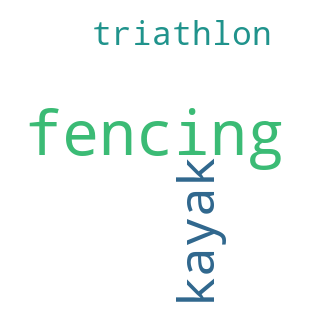

In [25]:
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in data_Athletes.sport:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 300, height = 300,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                       
plt.figure(figsize = (3, 3), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

35.Create a Regression Plot on Max V02 and mean BMI for any sport of your choice

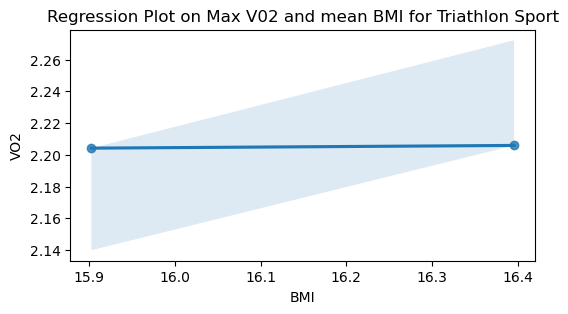

In [140]:
data_Athletes['Height_metre']=data_Athletes['Height']/100
#print('Height',data_Athletes['Height_metre'])
data_Athletes['BMI']=data_Athletes['Weight'] / (data_Athletes['Height_metre'] ** 2)
#print('BMI',data_Athletes['BMI'])
#print(data_Triathlon.head())

#print("Triathlon Data Columns:", data_Triathlon.columns)
#print("Athletes Data Columns:", data_Athletes.columns)

# Display the first few rows of the Triathlon DataFrame to inspect data
#print(data_Triathlon.head())
#print(data_Athletes.head())

# Inspect the VO2 columns to determine which one to use
#print(data_Triathlon[['VO2_x', 'VO2_y']].head())


################################
# Calculate Max VO2 for each athlete in data_Triathlon
max_vo2 = data_Triathlon.groupby('ID')['VO2'].max().reset_index()

#print(max_vo2)



# Merge data_Athletes with max_vo2
merged_data = data_Athletes[['ID', 'BMI']].merge(max_vo2, on='ID', how='left')

# Verify the combined data
#print(merged_data.head())


# Plotting
plt.figure(figsize=(6, 3))
sns.regplot(x='BMI', y='VO2', data=merged_data)
plt.title('Regression Plot on Max V02 and mean BMI for Triathlon Sport')
plt.xlabel('BMI')
plt.ylabel('VO2')
plt.show()


36.Plot the time series of HR( every 5 mins) of athlete 1

   ID     time     RR       VO2  power
0  11 -168.600  727.0  0.287147      0
1  11 -167.872  728.0  0.287147      0
2  11 -167.148  724.0  0.287147      0
3  11 -166.484  664.0  0.320580      0
4  11 -165.836  648.0  0.320580      0
       ID     time     RR       VO2  power
24459   1 -130.840  672.0  0.302008      0
24460   1 -130.168  672.0  0.302008      0
24461   1 -129.536  632.0  0.301336      0
24462   1 -128.824  712.0  0.301336      0
24463   1 -127.948  876.0  0.301336      0


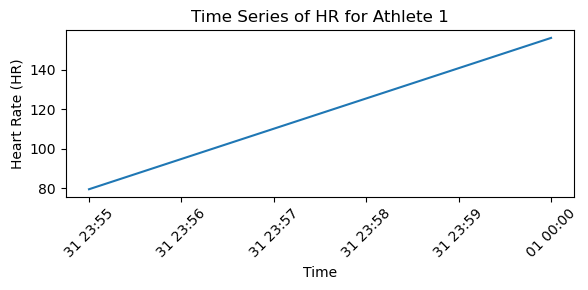

In [164]:
print(data_merged_sheet.head())
athelete_1=data_merged_sheet[data_merged_sheet['ID']==1]
print(athelete_1.head())
athelete_1['time'] = pd.to_datetime(athelete_1['time'])
athelete_1.set_index('time', inplace=True)
athelete_1_series = athelete_1.resample('5T').mean()
#RR=data_Fencing['RR']
athelete_1_series['HR'] = 60 / (athelete_1_series['RR'] / 1000)
# Plotting
plt.figure(figsize=(6, 3))
sns.lineplot(x=athelete_1_series.index, y=athelete_1_series['HR'])  # Replace 'HR' with the actual HR column name
plt.title('Time Series of HR for Athlete 1')
plt.xlabel('Time')
plt.ylabel('Heart Rate (HR)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

37.What was the maximum power achieved in terms of watts,
which participant achieved it? Display name, sport and watts.

In [290]:
combined_sports = pd.concat([data_Kayaking[['ID', 'power']], 
                             data_Triathlon[['ID', 'power']], 
                             data_Fencing[['ID', 'power']]])
#print(combined_sports.head())
max_power = combined_sports['power'].max()
max_power_id = combined_sports[combined_sports['power'] == max_power]['ID'].iloc[0]
athlete_info = data_Athletes[['ID', 'First Name', 'Last Name', 'sport']]
max_power_participant = athlete_info[athlete_info['ID'] == max_power_id]

# Display the result
print(f"Maximum Power Achieved: {max_power} watts")
print(f"Participant Details:")
print(f"Name: {max_power_participant['First Name'].values[0]} {max_power_participant['Last Name'].values[0]}")
print(f"Sport: {max_power_participant['sport'].values[0]}")
print(f"Watts: {max_power}")

Maximum Power Achieved: 335 watts
Participant Details:
Name: Isabella Griffin
Sport: kayak
Watts: 335


38.What is the average  difference in IBI during the warm up Vs the actual test?

In [208]:
# Define the end of the warm-up period and the start of the test period
warm_up_end = 0  # Warm-up ends at time = 0
#test_start = warm_up_end + 1

# Segment the data based on the time_in_seconds
warm_up_data = data_merged_sheet[data_merged_sheet['time_in_seconds'] <= warm_up_end]
#test_data = data_merged_sheet[data_merged_sheet['time_in_seconds'] >= test_start]

# Calculate the average IBI (RR interval) for each phase
average_ibi_warm_up = warm_up_data['RR'].mean()
average_ibi_test = data_merged_sheet['RR'].mean()

# Find the average difference in IBI
average_difference = average_ibi_test - average_ibi_warm_up

print(f"Average IBI during warm-up: {average_ibi_warm_up:.2f} ms")
print(f"Average IBI during test: {average_ibi_test:.2f} ms")
print(f"Average difference in IBI between warm-up and test: {average_difference:.2f} ms")



Average IBI during warm-up: 732.00 ms
Average IBI during test: 443.10 ms
Average difference in IBI between warm-up and test: -288.90 ms


39.Print out what's in indexes 7, 10, and 3 for the array in Q33.

In [344]:
list_items=[list[i] for i in [7,10,3]]
tupple_items=[tuple[i] for i in [7,10,3]]
print('list items : ',list_items)
print('tuple items: ',tupple_items)

list items :  [['venba'], 33.33, 100]
tuple items:  [8, 55, 33.5]


40.     [ 1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10],
       [11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20],
       [21, 22, 23, 24, 25],
       [26, 27, 28, 29, 30]  Use array slicing to display elements 1,3,5. If the value is less than 4 display it as 99

In [354]:
array = np.array([
    [1, 2, 3, 4, 5],
    [6, 7, 8, 9, 10],
    [11, 12, 13, 14, 15],
    [16, 17, 18, 19, 20],
    [21, 22, 23, 24, 25],
    [26, 27, 28, 29, 30]
])

var=[]

for row in array:
    extract_elements=[row[i] if i <len(row) else None for i in [1,3,4]]
    extract_elements=[99 if j is not None and j<4 else j for j in extract_elements]
    var.append(extract_elements)


for k,n in enumerate(var):
    print(f"Row{k}:{n}")
    


Row0:[99, 4, 5]
Row1:[7, 9, 10]
Row2:[12, 14, 15]
Row3:[17, 19, 20]
Row4:[22, 24, 25]
Row5:[27, 29, 30]
